## Задание к занятию «Модели ARIMA и GARCH, прогнозирование значений на их основе»

### Описание задания:
Выберите ряд и постройте его модель ARIMA/GARCH. Отчет нужно будет оформить в jupyter-ноутбук.
Дополнительное задание: попробуйте спрогнозировать график классическим ML.

In [49]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt
from arch import arch_model

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [52]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [53]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl



### Загрузка данных

In [54]:
series = pd.read_csv("chemical-concentration-readings.csv")['Level']

In [55]:
aic, order, mdl = _get_best_model(series)

aic:    inf | order: None


Results of Dickey-Fuller Test:
Test Statistic                  -2.022489
p-value                          0.276801
#Lags Used                       6.000000
Number of Observations Used    190.000000
Critical Value (1%)             -3.465244
Critical Value (5%)             -2.876875
Critical Value (10%)            -2.574945
dtype: float64


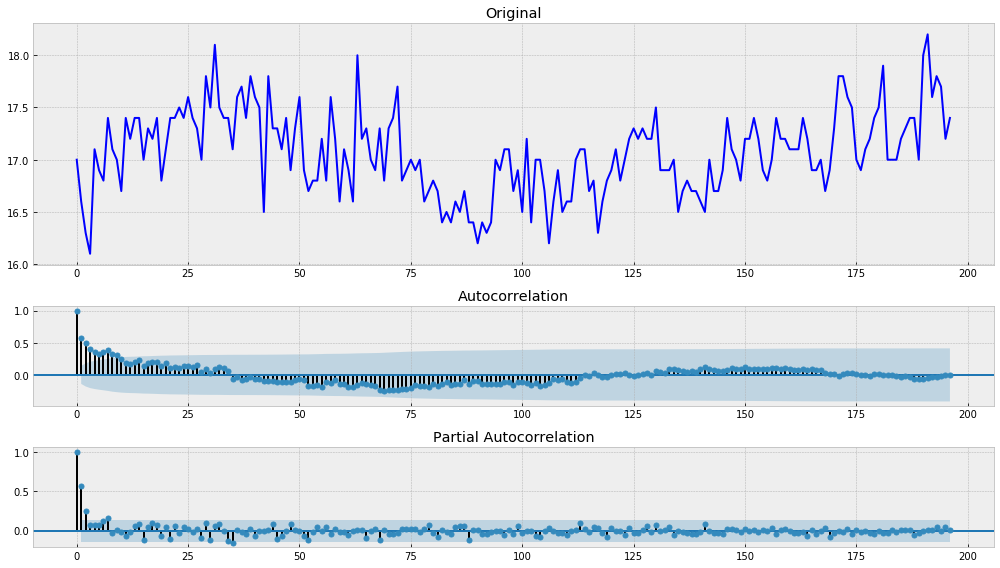

In [56]:
tsplot(series)

### Продифференцируем и уберем цикличность

In [57]:

series = series.values
series = series[1:] - series[:-1]

Results of Dickey-Fuller Test:
Test Statistic                -9.950874e+00
p-value                        2.516794e-17
#Lags Used                     5.000000e+00
Number of Observations Used    1.900000e+02
Critical Value (1%)           -3.465244e+00
Critical Value (5%)           -2.876875e+00
Critical Value (10%)          -2.574945e+00
dtype: float64


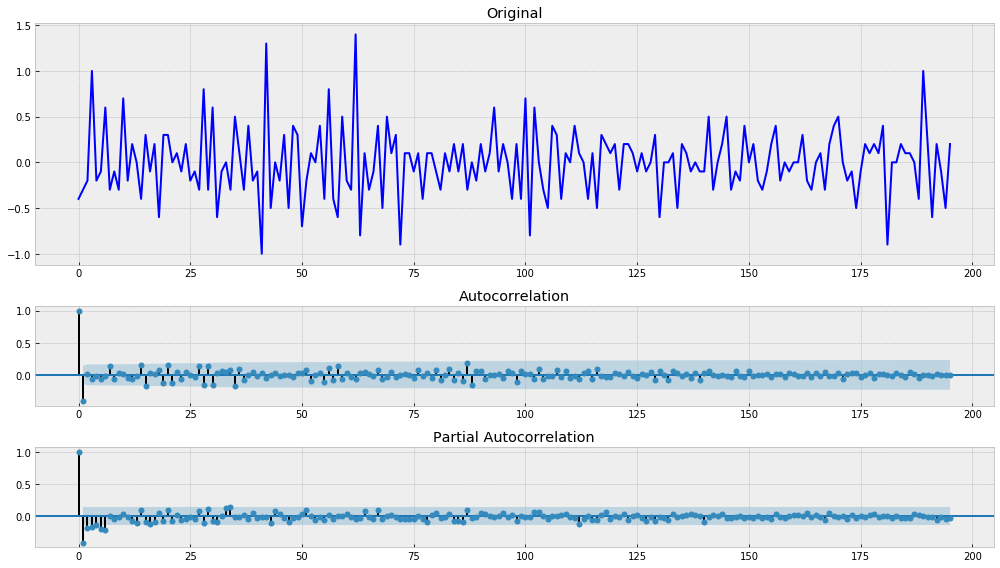

In [58]:
tsplot(series)

## GARCH

In [59]:
#GridSearch по параметрам модели GARCH
aic, order, mdl = _get_best_model(series)


aic: 104.89502 | order: (2, 0, 3)


In [60]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     59,   Neg. LLF: 74.97553779984926
Iteration:     10,   Func. Count:    112,   Neg. LLF: 72.314321720132
Iteration:     15,   Func. Count:    162,   Neg. LLF: 72.28793550406058
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 72.28549062610517
            Iterations: 18
            Function evaluations: 192
            Gradient evaluations: 18
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:               -72.2855
Distribution:      Standardized Student's t   AIC:                           160.571
Method:                  Maximum Likelihood   BIC:                           186.796
                                              No. Observations:  

Results of Dickey-Fuller Test:
Test Statistic                -9.950874e+00
p-value                        2.516794e-17
#Lags Used                     5.000000e+00
Number of Observations Used    1.900000e+02
Critical Value (1%)           -3.465244e+00
Critical Value (5%)           -2.876875e+00
Critical Value (10%)          -2.574945e+00
dtype: float64


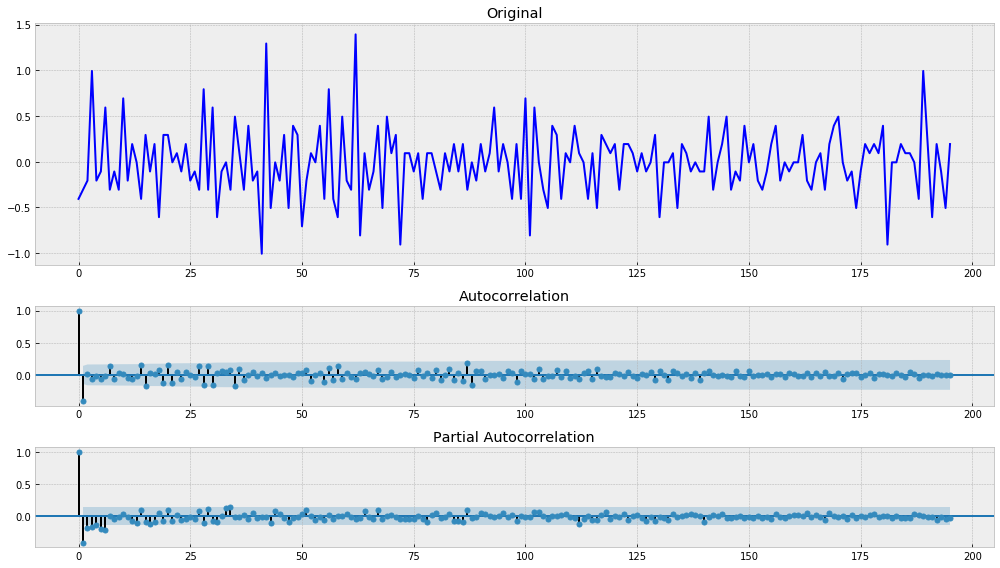

In [61]:
#Смотрим на остатки. Похоже на случайный шум. Значит модель хорошо описывает временной ряд.
tsplot(res.resid)

## Используем классический ML

In [62]:
series = pd.read_csv("chemical-concentration-readings.csv")['Level']

In [63]:
def plot_ts_and_points(ts, start_point, step):
    new_series = [None for i in range(len(ts))]
    for i in range(len(ts)):
        pos = start_point + step * i
        if pos >= len(ts):
            break
        new_series[pos] = ts[pos]
    new_series = pd.Series(new_series)
    
    with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        ts_ax = plt.axes()
        ts.plot(ax=ts_ax, color='blue')
        new_series.plot(ax=ts_ax, style='ro')

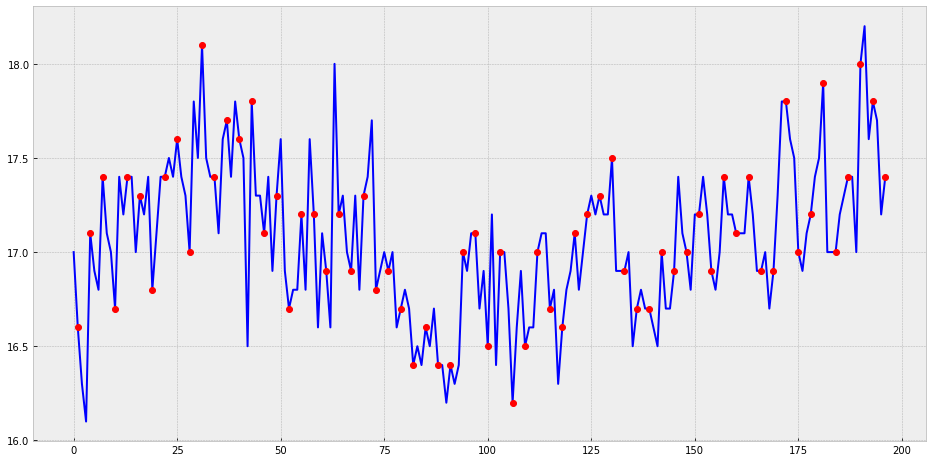

In [64]:
plot_ts_and_points(series, 1, 3)

In [65]:
series = pd.DataFrame(series)

In [66]:
type(series)

pandas.core.frame.DataFrame

In [67]:
series = series.reset_index()

In [68]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Level.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["index"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Level"], axis=1)
    y_train = data.loc[:test_index]["Level"]
    X_test = data.loc[test_index:].drop(["Level"], axis=1)
    y_test = data.loc[test_index:]["Level"]
    
    return X_train, X_test, y_train, y_test

In [69]:
X_train, X_test, y_train, y_test = prepareData(series, lag_start=1, lag_end=3, test_size=0.4)

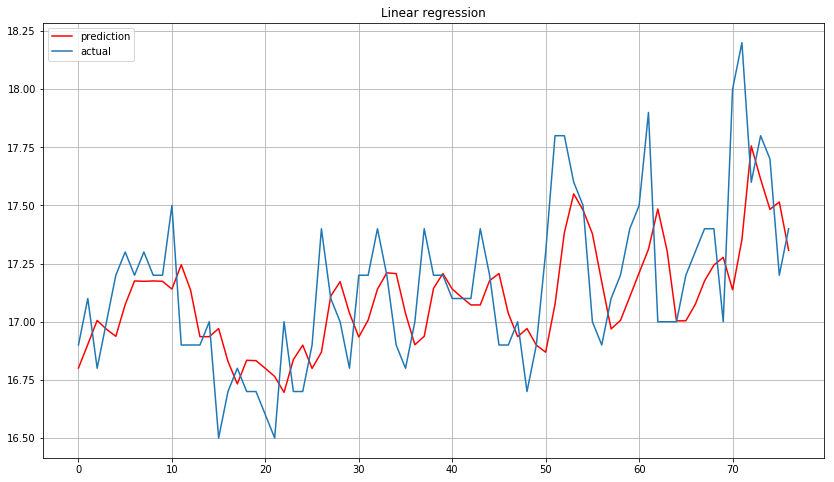

In [70]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);